In [1]:
import pandas as pd
import matplotlib.pyplot as plt  # 用来绘图的库
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers import GRU
from keras import optimizers
from sklearn.svm import SVR
import numpy as np
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EA_NAME = ['soea_DE_best_1_bin_templet','soea_DE_best_1_L_templet','soea_DE_rand_1_bin_templet',
           'soea_SGA_templet','soea_EGA_templet','soea_steadyGA_templet','soea_studGA_templet','soea_SEGA_templet']#就最后一个有用


In [2]:
def calcul_indicator(y,yhat):
    EV = 1 - np.var(y - yhat)/np.var(y)
    MAE = np.sum(np.abs((y - yhat)))/len(y)
    MSE = np.sum(np.multiply((y - yhat),(y - yhat)))/len(y)
    RMSE = sqrt(MSE)
    R_square = 1 - (((y - yhat)**2).sum())/(((y - y.mean())**2).sum())
    return [EV,MAE,MSE,RMSE,R_square]

class AClonalSelectionAlgorithm:
    def __init__(self, fitness_func, num_parameters, population_size, clone_factor, max_mutation_rate, min_mutation_rate, num_generations,early_stop):
        self.fitness_func = fitness_func
        self.num_parameters = num_parameters
        self.population_size = population_size
        self.clone_factor = clone_factor
        self.max_mutation_rate = max_mutation_rate
        self.min_mutation_rate = min_mutation_rate
        self.num_generations = num_generations
        self.early_stop = early_stop  # 提前停止的代数阈值
        

    def initialize_population(self):
        # 使用拉丁超立方抽样生成初始种群
        initial_population = lhs(self.num_parameters, samples=self.population_size)
        return initial_population
    
    
    def clone(self, population, fitness_values):
        # 计算最大适应度值
        max_fitness = np.max(fitness_values)
        min_fitness = np.min(fitness_values)
        # 计算个体的调整适应度值,确保值在(0, 1]范围内
        adjusted_fitness = (max_fitness - fitness_values + 1e-10) / (max_fitness - min_fitness + 1e-10)
        
        # 创建一个字典来存储个体及其对应的调整适应度值
        fitness_dict = {tuple(antibody): fitness for antibody, fitness in zip(population, adjusted_fitness)}
        
        clones = []
        for antibody, fitness in zip(population, adjusted_fitness):
            # 计算克隆数量,根据调整适应度值和克隆因子
            num_clones = int(self.clone_factor * fitness)
            
            # 生成克隆个体
            clones.extend([antibody.copy() for _ in range(num_clones)])
        
        # 如果克隆数量不足以填充种群,随机生成个体进行补充
        if len(clones) < self.population_size:
            num_new = self.population_size - len(clones)
            new_antibodies = [self.create_antibody() for _ in range(num_new)]
            clones.extend(new_antibodies)
        # 如果克隆数量超过种群大小,删除适应度差的多余的个体
        elif len(clones) > self.population_size:
             clones = sorted(clones, key=lambda x: fitness_dict.get(tuple(x), -np.inf), reverse=True)[:self.population_size]
        
        return np.array(clones)
    
    # def clone(self, population, fitness_values):
    #     # 计算最大适应度值
    #     max_fitness = np.max(fitness_values)
    #     min_fitness = np.min(fitness_values)
    #     # 计算个体的调整适应度值,确保值在(0, 1]范围内
    #     adjusted_fitness = (max_fitness - fitness_values + 1e-10) / (max_fitness - min_fitness + 1e-10)

    #     clones = []
    #     for antibody, fitness in zip(population, adjusted_fitness):
    #         # 计算克隆数量,根据调整适应度值和克隆因子
    #         num_clones = int(self.clone_factor * fitness)
    #         # 至少保留一个克隆
    #         num_clones = max(1, num_clones)
    #         clones.extend([antibody.copy() for _ in range(num_clones)])

    #     return np.array(clones)
    
    def adaptive_mutation(self, fitness, min_fitness, max_fitness):
        relative_fitness = (fitness - min_fitness) / (max_fitness - min_fitness + 1e-10)  # 添加一个小的正数,以避免除以零
        mutation_rate = self.max_mutation_rate - (self.max_mutation_rate - self.min_mutation_rate) * relative_fitness
        return np.clip(mutation_rate, self.min_mutation_rate, self.max_mutation_rate)
        
  
    def mutate(self, clones, fitness_values):
        min_fitness = np.min(fitness_values)
        max_fitness = np.max(fitness_values)
        for idx, clone in enumerate(clones):
            mutation_rate = self.adaptive_mutation(fitness_values[idx], min_fitness, max_fitness)
            mutation_mask = np.random.rand(self.num_parameters) < mutation_rate
            gaussian_noise = np.random.normal(0, mutation_rate, size=np.sum(mutation_mask))
            clone[mutation_mask] = np.clip(clone[mutation_mask] + gaussian_noise, 0, 1)  # 将变异后的参数值裁剪到 [0, 1] 区间内
        return clones
        

    def select(self, population, clones):
        combined = np.vstack((population, clones))
        fitness_values = np.apply_along_axis(self.fitness_func, 1, combined)
        best_indices = np.argsort(fitness_values)[:self.population_size]
        return combined[best_indices]
    
    def optimize(self):
        population = self.initialize_population()
        best_fitness = np.inf  # 初始化为无穷大
        no_improvement_count = 0  # 记录连续无改进的代数
        for _ in range(self.num_generations):
            fitness_values = np.apply_along_axis(self.fitness_func, 1, population)
            curr_best_fitness = np.min(fitness_values)

            # 如果当前最佳适应度值比之前的最佳值更好,则更新最佳值,并重置无改进计数器
            if curr_best_fitness < best_fitness:
                best_fitness = curr_best_fitness
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # 如果连续多代无改进,则提前停止
            if no_improvement_count >= self.early_stop:
                break
            clones = self.clone(population, fitness_values)
            mutated_clones = self.mutate(clones, fitness_values)
            population = self.select(population, mutated_clones)
        best_index = np.argmin(np.apply_along_axis(self.fitness_func, 1, population))
        return population[best_index] 
    

class ModifiedClonalSelectionAlgorithm:
    def __init__(self, fitness_func, num_parameters, population_size, clone_factor, mutation_rate, num_generations, early_stop):
        self.fitness_func = fitness_func
        self.num_parameters = num_parameters
        self.population_size = population_size
        self.clone_factor = clone_factor
        self.mutation_rate = mutation_rate
        self.num_generations = num_generations
        self.early_stop = early_stop  # 提前停止的代数阈值

    def initialize_population(self):
        # 使用均匀随机初始化
        initial_population = np.random.rand(self.population_size, self.num_parameters)
        return initial_population

    def clone(self, population, fitness_values):
        # 计算最大适应度值
        max_fitness = np.max(fitness_values)
        min_fitness = np.min(fitness_values)
        # 计算个体的调整适应度值,确保值在(0, 1]范围内
        adjusted_fitness = (max_fitness - fitness_values + 1e-10) / (max_fitness - min_fitness + 1e-10)

        clones = []
        for antibody, fitness in zip(population, adjusted_fitness):
            # 计算克隆数量,根据调整适应度值和克隆因子
            num_clones = int(self.clone_factor * fitness)
            clones.extend([antibody.copy() for _ in range(num_clones)])

        # 如果克隆数量不足以填充种群,随机生成个体进行补充
        if len(clones) < self.population_size:
            num_new = self.population_size - len(clones)
            new_antibodies = np.random.rand(num_new, self.num_parameters)
            clones.extend(new_antibodies)

        return np.array(clones)

    def mutate(self, clones):
        # 使用固定的变异率
        mutation_mask = np.random.rand(len(clones), self.num_parameters) < self.mutation_rate
        gaussian_noise = np.random.normal(0, self.mutation_rate, size=np.sum(mutation_mask))
        clones[mutation_mask] = np.clip(clones[mutation_mask] + gaussian_noise, 0, 1)  # 将变异后的参数值裁剪到 [0, 1] 区间内
        return clones

    def select(self, population, clones):
        combined = np.vstack((population, clones))
        fitness_values = np.apply_along_axis(self.fitness_func, 1, combined)
        best_indices = np.argsort(fitness_values)[:self.population_size]
        return combined[best_indices]

    def optimize(self):
        population = self.initialize_population()
        best_fitness = np.inf  # 初始化为无穷大
        no_improvement_count = 0  # 记录连续无改进的代数
        for _ in range(self.num_generations):
            fitness_values = np.apply_along_axis(self.fitness_func, 1, population)
            curr_best_fitness = np.min(fitness_values)

            # 如果当前最佳适应度值比之前的最佳值更好,则更新最佳值,并重置无改进计数器
            if curr_best_fitness < best_fitness:
                best_fitness = curr_best_fitness
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # 如果连续多代无改进,则提前停止
            if no_improvement_count >= self.early_stop:
                break

            clones = self.clone(population, fitness_values)
            mutated_clones = self.mutate(clones)
            population = self.select(population, mutated_clones)

        best_index = np.argmin(np.apply_along_axis(self.fitness_func, 1, population))
        return population[best_index]   

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def RandomForest(train_X,train_y,test_X,test_y):
    model = RandomForestRegressor(n_estimators=25)
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def Adaboost(train_X,train_y,test_X,test_y):
    model = AdaBoostRegressor(n_estimators=50)
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def LR(train_X,train_y,test_X,test_y):
    model = Sequential()
    model.add(Dense(1, input_dim=train_X.shape[1]))
    model.compile(loss='mse', optimizer='Adam')
    history = model.fit(train_X, train_y, batch_size=32, epochs=60, validation_data=(test_X, test_y), verbose=1,
                        shuffle=False)
    yhat = model.predict(test_X)
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def SVRR(train_X,train_y,test_X,test_y):
    model = SVR(kernel='poly')
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)


def LSTMM(train_X,train_y,test_X,test_y):
    # 将数据转换成3D进行输入
    train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # Compile model
    learning_rate = 0.0003
    decay_rate = learning_rate / 100
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate,
                                             nesterov=False)
    model.compile(loss='mse', optimizer=sgd)
   
    history = model.fit(train_X_LSTM, train_y, epochs=60, batch_size=32, validation_data=(test_X_LSTM, test_y),
                        verbose=1, shuffle=False)
    yhat = model.predict(test_X_LSTM)
   
    yhat = yhat.reshape(len(yhat), 1)

    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y,yhat)


def OptimizedLSTM(train_X, train_y, test_X, test_y, calcul_indicator):
    def lstm_fitness(params):
        # 这部分代码保持不变
        train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

        num_units = 50 + int(params[0] * 150)  # LSTM 单元数 (50 to 150)
        dropout_rate = params[2]*0.5  # Dropout率 (0 to 0.5)
        learning_rate = params[1] * 0.01 + 0.0001  # 学习率 (0.0001 to 0.01)  
        epochs = 30 + int(params[3] * 100)  # epochs (50 to 150)
        batch_size = 8+ int(params[4] * 120)  # batch_size (2 to 100)
        
        model = Sequential()
        model.add(LSTM(num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

        decay_rate = 0.000003
        momentum = 0.5
        sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
        model.compile(loss='mse', optimizer=sgd)

        history = model.fit(train_X_LSTM, train_y, epochs= epochs , batch_size= batch_size, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)
        yhat = model.predict(test_X_LSTM)
        yhat = yhat.reshape(len(yhat), 1)
        test_y_reshaped = test_y.reshape(len(test_y), 1)

        indicators = calcul_indicator(test_y_reshaped, yhat)
        fitness = indicators[3]  # RMSE作为适应度值
        return fitness

    # 使用克隆选择算法找到最优参数
    acsa = AClonalSelectionAlgorithm(lstm_fitness,5 , 15, 4, 0.6, 0.1, 20, 3)
    best_params = acsa.optimize()

    # 使用最优参数训练LSTM模型
    best_num_units = 50 + int(best_params[0] * 150)
    best_learning_rate = best_params[1] * 0.01 + 0.0001
    best_dropout = best_params[2]*0.5
    best_epochs = 30 + int(best_params[3] * 100)  # epochs (50 to 150)
    best_batch_size = 8+ int(best_params[4] * 120)  # batch_size (2 to 100)

    train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    model = Sequential()
    model.add(LSTM(best_num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
    model.add(Dropout(best_dropout))
    model.add(Dense(1))

    decay_rate = 0.000003
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=best_learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss='mse', optimizer=sgd)

    history = model.fit(train_X_LSTM, train_y, epochs=best_epochs , batch_size=best_batch_size , validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)

    yhat = model.predict(test_X_LSTM)
    yhat = yhat.reshape(len(yhat), 1)
    test_y_reshaped = test_y.reshape(len(test_y), 1)

    # 绘制损失曲线
    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # 返回模型评估结果和最优参数
    return calcul_indicator(test_y_reshaped, yhat)


def TraditionalClonalLSTM(train_X, train_y, test_X, test_y, calcul_indicator):
    def lstm_fitness(params):
        # 这部分代码保持不变
        train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

        num_units = 50 + int(params[0] * 150)  # LSTM 单元数 (50 to 150)
        dropout_rate = params[1] * 0.5  # Dropout率 (0 to 0.5)
        learning_rate = params[2] * 0.01 + 0.0001  # 学习率 (0.0001 to 0.01)
        epochs = 30 + int(params[3] * 100)  # epochs (50 to 150)
        batch_size = 8 + int(params[4] * 120)  # batch_size (2 to 100)
        
        model = Sequential()
        model.add(LSTM(num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

        decay_rate = 0.000003
        momentum = 0.5
        sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
        model.compile(loss='mse', optimizer=sgd)

        history = model.fit(train_X_LSTM, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)
        yhat = model.predict(test_X_LSTM)
        yhat = yhat.reshape(len(yhat), 1)
        test_y_reshaped = test_y.reshape(len(test_y), 1)

        indicators = calcul_indicator(test_y_reshaped, yhat)
        fitness = indicators[3]  # RMSE作为适应度值
        return fitness

    # 使用传统克隆选择算法找到最优参数
    mcsa = ModifiedClonalSelectionAlgorithm(lstm_fitness, 5, 15, 4, 0.3, 20,3)
    best_params = mcsa.optimize()

    # 使用最优参数训练LSTM模型
    best_num_units = 50 + int(best_params[0] * 150)
    best_dropout = best_params[1] * 0.5
    best_learning_rate = best_params[2] * 0.01 + 0.0001
    best_epochs = 30 + int(best_params[3] * 100)  # epochs (50 to 150)
    best_batch_size = 8 + int(best_params[4] * 120)  # batch_size (2 to 100)

    train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    model = Sequential()
    model.add(LSTM(best_num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
    model.add(Dropout(best_dropout))
    model.add(Dense(1))

    decay_rate = 0.000003
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=best_learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss='mse', optimizer=sgd)

    history = model.fit(train_X_LSTM, train_y, epochs=best_epochs, batch_size=best_batch_size, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)

    yhat = model.predict(test_X_LSTM)
    yhat = yhat.reshape(len(yhat), 1)
    test_y_reshaped = test_y.reshape(len(test_y), 1)

    # 绘制损失曲线
    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # 返回模型评估结果和最优参数
    return calcul_indicator(test_y_reshaped, yhat)


C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:43: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = Adaboost(train_X,train_y,test_X,test_y)


Epoch 1/60
23/23 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0282
Epoch 2/60
23/23 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0253
Epoch 3/60
23/23 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0306
Epoch 4/60
23/23 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0256
Epoch 5/60
23/23 [==============================] - 0s 955us/step - loss: 0.0049 - val_loss: 0.0249
Epoch 6/60
23/23 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0229
Epoch 7/60
23/23 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0213
Epoch 8/60
23/23 [==============================] - 0s 1000us/step - loss: 0.0039 - val_loss: 0.0198
Epoch 9/60
23/23 [==============================] - 0s 1000us/step - loss: 0.0036 - val_loss: 0.0184
Epoch 10/60
23/23 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0171
Epoch 11/60

C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:45: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)


Epoch 1/60
23/23 [==============================] - 1s 9ms/step - loss: 0.1707 - val_loss: 0.7015
Epoch 2/60
23/23 [==============================] - 0s 2ms/step - loss: 0.1576 - val_loss: 0.6690
Epoch 3/60
23/23 [==============================] - 0s 2ms/step - loss: 0.1456 - val_loss: 0.6389
Epoch 4/60
23/23 [==============================] - 0s 2ms/step - loss: 0.1348 - val_loss: 0.6109
Epoch 5/60
23/23 [==============================] - 0s 2ms/step - loss: 0.1244 - val_loss: 0.5848
Epoch 6/60
23/23 [==============================] - 0s 2ms/step - loss: 0.1164 - val_loss: 0.5604
Epoch 7/60
23/23 [==============================] - 0s 2ms/step - loss: 0.1070 - val_loss: 0.5377
Epoch 8/60
23/23 [==============================] - 0s 2ms/step - loss: 0.1007 - val_loss: 0.5165
Epoch 9/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0941 - val_loss: 0.4965
Epoch 10/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0884 - val_loss: 0.4778
Epoch 11/60
23/23 [

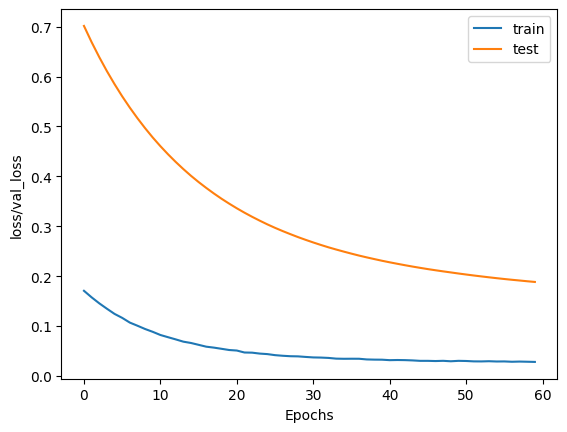

C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:49: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LSTMM(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:43: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new ar

Epoch 1/60
23/23 [==============================] - 0s 3ms/step - loss: 0.0764 - val_loss: 0.0290
Epoch 2/60
23/23 [==============================] - 0s 909us/step - loss: 0.0640 - val_loss: 0.0344
Epoch 3/60
23/23 [==============================] - 0s 955us/step - loss: 0.0562 - val_loss: 0.0356
Epoch 4/60
23/23 [==============================] - 0s 1ms/step - loss: 0.0502 - val_loss: 0.0350
Epoch 5/60
23/23 [==============================] - 0s 1ms/step - loss: 0.0454 - val_loss: 0.0338
Epoch 6/60
23/23 [==============================] - 0s 909us/step - loss: 0.0414 - val_loss: 0.0325
Epoch 7/60
23/23 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0313
Epoch 8/60
23/23 [==============================] - 0s 1000us/step - loss: 0.0354 - val_loss: 0.0302
Epoch 9/60
23/23 [==============================] - 0s 1000us/step - loss: 0.0331 - val_loss: 0.0293
Epoch 10/60
23/23 [==============================] - 0s 955us/step - loss: 0.0313 - val_loss: 0.0285
Epoch

C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:45: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)


23/23 [==============================] - 1s 9ms/step - loss: 0.1079 - val_loss: 0.1056
Epoch 2/60
23/23 [==============================] - 0s 2ms/step - loss: 0.1019 - val_loss: 0.0997
Epoch 3/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0967 - val_loss: 0.0942
Epoch 4/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0919 - val_loss: 0.0890
Epoch 5/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0870 - val_loss: 0.0842
Epoch 6/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.0797
Epoch 7/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0754
Epoch 8/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0715
Epoch 9/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0678
Epoch 10/60
23/23 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0644
Epoch 11/60
23/23 [===========

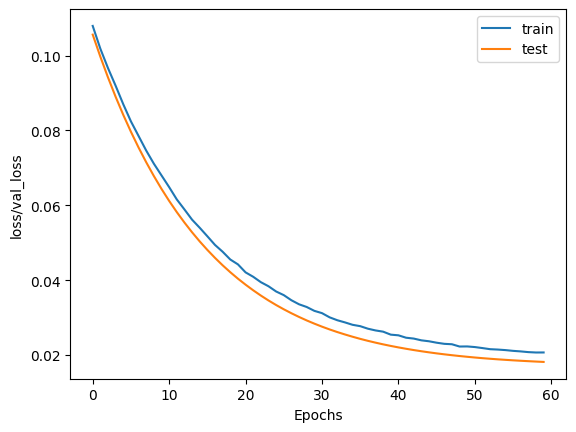

C:\Users\han\AppData\Local\Temp\ipykernel_1860\1800688017.py:49: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LSTMM(train_X,train_y,test_X,test_y)


Epoch 1/52
11/11 [==============================] - 1s 18ms/step - loss: 0.1641 - val_loss: 0.5944
Epoch 2/52
11/11 [==============================] - 0s 3ms/step - loss: 0.0894 - val_loss: 0.4273
Epoch 3/52
11/11 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.3321
Epoch 4/52
11/11 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.2752
Epoch 5/52
11/11 [==============================] - 0s 3ms/step - loss: 0.0432 - val_loss: 0.2395
Epoch 6/52
11/11 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.2165
Epoch 7/52
11/11 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.2005
Epoch 8/52
11/11 [==============================] - 0s 3ms/step - loss: 0.0387 - val_loss: 0.1888
Epoch 9/52
11/11 [==============================] - 0s 3ms/step - loss: 0.0374 - val_loss: 0.1802
Epoch 10/52
11/11 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.1734
Epoch 11/52
11/11 

IndexError: index 15 is out of bounds for axis 0 with size 15

In [3]:
if __name__ == '__main__':
    areas = ['DS4']
    indicator = ['EV','MAE','MSE','RMSE','R_square']

    # 如果是需要改动对比的算法，在这里进行改进即可
    classifers = ['RF','Adaboost','LinearRegression','SVR','LSTM','SEGA-RF','SEGA-Adaboost','SEGA-LinearRegression','SEGA-SVR','SEGA-LSTM','AClonalSelection','ClonalSelection', 'SEGA-ClonalSelection','SEGA-AClonalSelection']
    df = pd.DataFrame(columns=classifers, index=indicator)
    #df = pd.DataFrame()
    for area in areas:
        path = './{}/'.format(area)
        pre_data_df = pd.read_csv(path+'8area_{}.csv'.format(area))
        # 对每种方法进行遍历
        for method in classifers:
            data_df  =pre_data_df
            if method[:3]=='SEG':
                res = pd.read_csv(path+'soea_SEGA_templet/optPop/Chrom.csv',header=None)
                values = res.values
                features = data_df.columns[1:]
                best_features = []
                best_features.append('label_M')
                for index in range(values.shape[1]):
                     if values[0][index] == 1:#筛选出来的特征，如果是1则选上，如果是0，则不选。
                         best_features.append(features[index])
                data_df = data_df[best_features]
            values = data_df.values
            values = values.astype('float32')
            #进行标准化的操作
            scaler = MinMaxScaler(feature_range = (0,1))
            scaled = scaler.fit_transform(values)
            reframed = series_to_supervised(scaled,1,1)
            reframed.drop(reframed.columns[[i for i in range(int(reframed.shape[1] / 2) + 1, reframed.shape[1])]], axis=1,inplace=True)

            #split into input
            values = reframed.values
            n_train_hours = int(reframed.shape[0]*0.7)
            train = values[:n_train_hours:]
            test = values[n_train_hours:,:]
            train_X,train_y = train[:,:-1],train[:,-1]
            test_X ,test_y = test[:,:-1],test[:,-1]
            if re.search('RF', method):
                df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)
            elif re.search('Adaboost',method):
                df.loc[:,method] = Adaboost(train_X,train_y,test_X,test_y)
            elif re.search('LinearRegression',method):
                df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
            elif re.search('SVR', method):
                df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)
            elif re.search('LSTM', method):
                df.loc[:,method] = LSTMM(train_X,train_y,test_X,test_y)
            elif re.search('AClonalSelection', method):
                indicators = OptimizedLSTM(train_X, train_y, test_X, test_y, calcul_indicator)
                df.loc[:,method]=indicators
            elif re.search('ClonalSelection', method):
                indicators = TraditionalClonalLSTM(train_X, train_y, test_X, test_y, calcul_indicator)
                df.loc[:,method]=indicators
            df.to_csv(path+'comparision_methodsss_{}.csv'.format(area))